In [1]:
import pandas as pd
import numpy as np
import pylab
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
%matplotlib inline

Let's generate some data of the form

$y_t = 0.3y_{t - 1} - 0.2y_{t - 2} + 0.1\epsilon_{t - 1} + \epsilon_t$ where $\epsilon \sim N(0, 1)$

<AxesSubplot:>

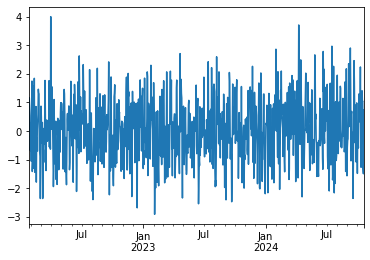

In [8]:
n = 1000

startdate = '2022-01-25'
daterange = pd.date_range(start=startdate, periods=n)

empty_dataset = np.zeros(n)
mod = SARIMAX(empty_dataset, order=(2, 0, 1), initialization='diffuse')
series = pd.Series(mod.simulate([0.3, -0.2, 0.1, 1], n), index=daterange)
series.plot()

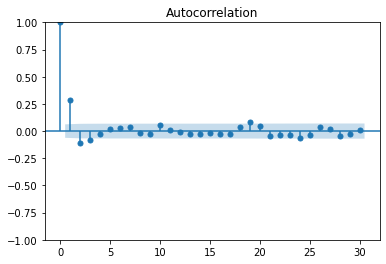

In [9]:
acf_plot = plot_acf(series)

The ACF more or less shuts off after one lag, without decaying to 0

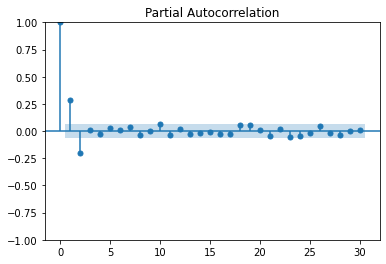

In [10]:
pacf_plot = plot_pacf(series, method='ywm')

The PACF basically shuts off after 2 lags

In [12]:
train_end = datetime(2024, 9, 1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):]

In [15]:
model = SARIMAX(train_data, order=(2, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  951
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -1338.682
Date:                Mon, 07 Feb 2022   AIC                           2685.363
Time:                        19:17:20   BIC                           2704.794
Sample:                    01-25-2022   HQIC                          2692.766
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2911      0.158      1.844      0.065      -0.018       0.600
ar.L2         -0.1902      0.054     -3.531      0.000      -0.296      -0.085
ma.L1          0.0473      0.161      0.294      0.7

Our predicted model is $hat{y_t} = 0.29y_{t - 1} - 0.19y_{t - 2} + 0.04\epsilon_{t - 1} + \epsilon_t$ where $\epsilon \sim N(0, 0.98)$

In [14]:
model = SARIMAX(series, order=(2, 0, 3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -1407.561
Date:                Mon, 07 Feb 2022   AIC                           2827.123
Time:                        19:15:05   BIC                           2856.569
Sample:                    01-25-2022   HQIC                          2838.315
                         - 10-20-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6730      0.011    145.919      0.000       1.651       1.695
ar.L2         -0.9797      0.011    -89.014      0.000      -1.001      -0.958
ma.L1         -1.3072      0.032    -40.803      0.0

/Users/arjunchandrasekhar/opt/anaconda3/envs/cmpinf2120/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


This is worse! Let's go back to the old model

In [16]:
model = SARIMAX(train_data, order=(2, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  951
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -1338.682
Date:                Mon, 07 Feb 2022   AIC                           2685.363
Time:                        19:17:43   BIC                           2704.794
Sample:                    01-25-2022   HQIC                          2692.766
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2911      0.158      1.844      0.065      -0.018       0.600
ar.L2         -0.1902      0.054     -3.531      0.000      -0.296      -0.085
ma.L1          0.0473      0.161      0.294      0.7

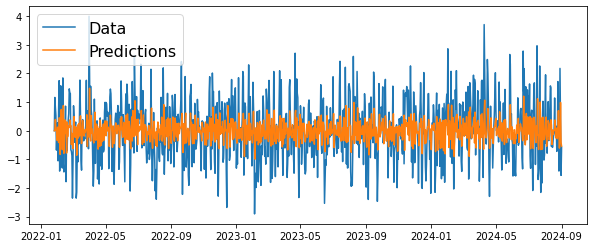

In [17]:
pylab.figure(figsize=(10,4))

pylab.plot(train_data)
pylab.plot(model_fit.predict(start=train_data.index[0], end=train_data.index[-1]))

pylab.legend(('Data', 'Predictions'), fontsize=16)

In [54]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [55]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

Text(0.5, 1.0, 'MA2 Simulation over time')

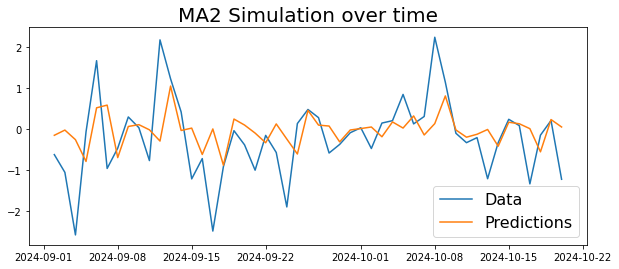

In [56]:
pylab.figure(figsize=(10,4))

pylab.plot(test_data)
pylab.plot(predictions)

pylab.legend(('Data', 'Predictions'), fontsize=16)

pylab.title('MA2 Simulation over time', fontsize=20)

In [57]:
residuals = test_data - predictions

In [58]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 1.2671


In [59]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.9255629051172168


Text(0, 0.5, 'Error')

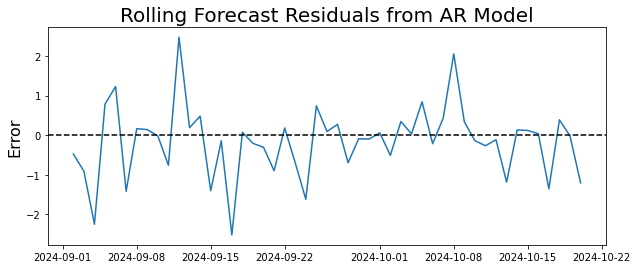

In [60]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = series[:train_end - timedelta(days=1)]
    model = SARIMAX(train_data, order=(0,0,2))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred
    
rolling_residuals = test_data - rolling_predictions
pylab.figure(figsize=(10,4))
pylab.plot(rolling_residuals)
pylab.axhline(0, linestyle='--', color='k')
pylab.title('Rolling Forecast Residuals from AR Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)

In [61]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 1.2697


In [62]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 0.9185342445872223
